In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
from keras.models import load_model
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import tensorflow as tf
from tensorflow.python.client import device_lib
import matplotlib.patches as mpatches
from scipy import signal



/home/sam/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
print("----------------------------")
print
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17424112189382142745
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 225050624
locality {
  bus_id: 1
}
incarnation: 11829992049241826259
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
----------------------------

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8805015386759404107
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 235929600
locality {
  bus_id: 1
}
incarnation: 11946207908692902117
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# TODO:
* Record trials in an organized excel sheet, or write out each one to a .txt file 
* 


## Generate sine wave data points

In [3]:
#Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.1
points_per_cycle = int((2*np.pi) / sample_rate)

#Sample from a pure sine wave
data = [np.abs(signal.sawtooth(i)) for i in np.arange(start=np.pi, stop=(num_cycles*2*np.pi) +np.pi, step=sample_rate)]

print("Total data points: " + str(len(data)))



Total data points: 1257


## Data Formatting
* `series_to_examples`: Function to convert a 1D series into example data consisting of `X` and `Y` columns
* `prepare_data`: Function to prepare and split data into `train`/`test` sets

* NOTE: We can also add scaling in these functions, to squash values closer together


In [4]:
# Convert 1D series into example data of X and Y columns
def series_to_examples(series, n_prev=1, n_forecast=1, dropnan=True):
    """
    Transform time series data into supervised learning dataset.
    Arguments: 
        series: Sequence of observations as a list
        n_prev: Number of lag observations as input (X)
        n_forecast: Number of observations to predict (Y)
        dropnan: Boolean to drop rows with NaN values resulting from shift
    Returns:
        Pandas Dataframe
        
    Note: by this logic we should have N = (n_prev + n_forecast) columns
     and (series_len - N + 1) rows
    """
    
    #Robust check for whether or not series is univariate or multi-variate
    #If not a simple list (univariate), then the columns of shape will tell you how many variables
    num_dims = 1 if type(series) is list else series.shape[1]
    
    #convert the series to a dataframe format for shift
    df = pd.DataFrame(series)
    
    #Cols is a list of lists where each inner list is a whole column
    cols, names = list(), list()
    
    #Build each column of the input, first column will be fully shifted (i.e oldest example seen) 
    for i in range(n_prev, 0, -1):
        cols.append(df.shift(i))
        #names just a list??
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build each column of the output forecasts (t, t+1, ...)
    for i in range(0, n_forecast):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_dims)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build a final dataframe columns side by side & attach names
    final = pd.concat(cols, axis=1)
    final.columns = names

    
    #Remove all rows with NaN values
    if dropnan:
        final.dropna(inplace=True)
        
    print("in series_to_examples")
    print(final.shape)
        
    return final  



#Prepare and split data into train/test sets
def prepare_data(series, n_test, n_prev, n_forecast):#, batch_size):
    
    #Prepare data handles intital split!!!
    
    #NEW: Split before sending into series_to_examples
    train, test = series[:-n_test], series[-n_test:] 
    
    
    #TODO: Could scale here
    
    #Grab supervised-formatted data
    df_train = series_to_examples(train, n_prev, n_forecast)
    
    #Drop excess examples to allow for varying batch size
    #cutoff = int(len(df_train)/batch_size) * batch_size
    #df_train = df_train[:cutoff]
    
    print("in prepare_data")
    print(df_train.shape)
    #Extract and retain structure of values from dataframe
    example_values_train = df_train.values
    
    return example_values_train, test


## Define data structure to be passed to network

In [5]:
#Test size has to be large enough to encompass one full cycle

n_prev = points_per_cycle * 3
n_forecast = points_per_cycle


#The test data has to encompass both n_prev points and n_forecast points
#We feed the first n_prev points of the test into the network to make a prediction and compare this to n_forecast
#(This is just enough to predict one cycle)
n_test = n_prev + n_forecast


train, test = prepare_data(data, n_test, n_prev, n_forecast)#, batch_size)

print(n_forecast)

in series_to_examples
(762, 248)
in prepare_data
(762, 248)
62


## Visualize total dataset and goal in red

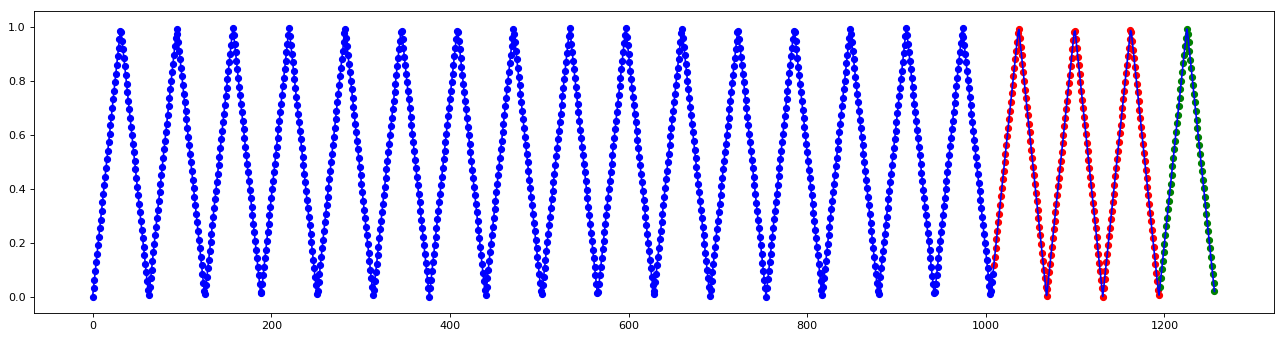

In [6]:
#Set the figure parameters
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Grab the points for each section of the plot
train_points, test_input_points, test_label_points = data[:-n_test], data[-n_test:-n_forecast], data[-n_forecast:]

#Plot the training data and the underlying curve in blue 
plt.plot(data, color="blue")
train_plot_x = [x for x in range(len(train_points))]
plt.scatter(train_plot_x, train_points, color="blue", s=30)

#Plot the test example X in red
test_input_xs = [x +len(train_points) for x in range(len(test_input_points))]
plt.scatter(test_input_xs, test_input_points, color="red", s=30)





#Plot the test target label in green
test_label_xs = [x +(len(train_points)+len(test_input_points)) for x in range(len(test_label_points))]
plt.scatter(test_label_xs, test_label_points, color="green", s=30)











# #Plot the original data using the defined train and test sizes

# #Line plot along the true data
# plt.plot(data, color="blue")

# #Plot the training points in green
# train_plot_x = [x for x in range(len(train_plot))]
# plt.scatter(train_plot_x, train_plot, color="blue", s=30)

# #Note: we have to shift the test data to plot it
# test_plot_x = [x +len(train_plot) for x in range(len(test_plot))]
# plt.scatter(test_plot_x, test_plot, color="red", s=30)


## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [7]:
# fit an LSTM network to training data

def fit_lstm(train, n_prev, n_forecast, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    
    #y = y.reshape(1, y.shape[0])
    
    #print(y.shape[1])
    
    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    architecture += "LSTM; "
    model.add(Dense(180))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy']) #Hod wants mean squared error
    
    
    
    
    #Fit the network to the training data
    history = model.fit(X, y, validation_split=0.2, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False)

    
#     for i in range(nb_epoch):
#         print(i)
#         start = timer()
#         model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
#         model.reset_states()
#         end = timer()
#         print("Epoch duration: " + str(end - start))
    return model, architecture, history

In [8]:
print(train.shape)
train = train[12:]
print(train.shape)

(762, 248)
(750, 248)


## Train the Neural Network

In [9]:
n_epochs = 1500
n_batch = 150
n_neurons = 200
print(len(train))
print(train.shape)
#model, architecture = fit_lstm(train, n_prev, n_forecast, n_batch, n_epochs, n_neurons)
model, architecture,history = fit_lstm(train, n_prev, n_forecast, n_batch, n_epochs, n_neurons)


750
(750, 248)
X shape: (750, 186)
y shape: (750, 62)
(150, 186, 1)
(750, 186, 1)
Train on 600 samples, validate on 150 samples
Epoch 1/1500
600/600 [==============================] - 2s 3ms/step - loss: 0.3080 - acc: 0.0167 - val_loss: 0.2577 - val_acc: 0.0200
Epoch 2/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.2041 - acc: 0.0250 - val_loss: 0.1482 - val_acc: 0.0133
Epoch 3/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.1247 - acc: 0.0167 - val_loss: 0.1058 - val_acc: 0.0333
Epoch 4/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.1025 - acc: 0.0183 - val_loss: 0.0976 - val_acc: 0.0200
Epoch 5/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0962 - acc: 0.0150 - val_loss: 0.0953 - val_acc: 0.0133
Epoch 6/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0916 - acc: 0.0083 - val_loss: 0.0881 - val_acc: 0.0133
Epoch 7/1500
600/600 [==============================] - 1s 2ms/step 

Epoch 61/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.5283 - val_loss: 0.0013 - val_acc: 0.5933
Epoch 62/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.5267 - val_loss: 0.0013 - val_acc: 0.5933
Epoch 63/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.5267 - val_loss: 0.0013 - val_acc: 0.5933
Epoch 64/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.5317 - val_loss: 0.0013 - val_acc: 0.5867
Epoch 65/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.5300 - val_loss: 0.0013 - val_acc: 0.5800
Epoch 66/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.5333 - val_loss: 0.0013 - val_acc: 0.5800
Epoch 67/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.5317 - val_loss: 0.0013 - val_acc: 0.5800
Epoch 68/1500
600/600 [==============================] 

600/600 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.4200 - val_loss: 0.0014 - val_acc: 0.5000
Epoch 122/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0014 - acc: 0.4117 - val_loss: 0.0014 - val_acc: 0.4867
Epoch 123/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0014 - acc: 0.4050 - val_loss: 0.0015 - val_acc: 0.4800
Epoch 124/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0014 - acc: 0.4100 - val_loss: 0.0015 - val_acc: 0.4733
Epoch 125/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0014 - acc: 0.4150 - val_loss: 0.0015 - val_acc: 0.4733
Epoch 126/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0014 - acc: 0.4133 - val_loss: 0.0015 - val_acc: 0.4600
Epoch 127/1500
600/600 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.4283 - val_loss: 0.0014 - val_acc: 0.4867
Epoch 128/1500
600/600 [==============================] - 1s 2m

600/600 [==============================] - 1s 2ms/step - loss: 4.2008e-04 - acc: 0.4000 - val_loss: 3.8194e-04 - val_acc: 0.4133
Epoch 180/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.9025e-04 - acc: 0.4000 - val_loss: 3.7678e-04 - val_acc: 0.4267
Epoch 181/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.9977e-04 - acc: 0.3983 - val_loss: 3.8390e-04 - val_acc: 0.4400
Epoch 182/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.9303e-04 - acc: 0.4033 - val_loss: 3.5497e-04 - val_acc: 0.4533
Epoch 183/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.6250e-04 - acc: 0.4033 - val_loss: 3.4314e-04 - val_acc: 0.4533
Epoch 184/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.6172e-04 - acc: 0.4083 - val_loss: 3.4331e-04 - val_acc: 0.4600
Epoch 185/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.5164e-04 - acc: 0.4150 - val_loss: 3.1803e-04 - val_acc: 0.4800
Epoch 1

Epoch 236/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.2887e-04 - acc: 0.6167 - val_loss: 2.2953e-04 - val_acc: 0.7800
Epoch 237/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.2867e-04 - acc: 0.6200 - val_loss: 2.2933e-04 - val_acc: 0.7800
Epoch 238/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.2838e-04 - acc: 0.6217 - val_loss: 2.2914e-04 - val_acc: 0.7933
Epoch 239/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.2814e-04 - acc: 0.6233 - val_loss: 2.2890e-04 - val_acc: 0.7933
Epoch 240/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.2776e-04 - acc: 0.6233 - val_loss: 2.2837e-04 - val_acc: 0.7867
Epoch 241/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.2717e-04 - acc: 0.6283 - val_loss: 2.2804e-04 - val_acc: 0.7867
Epoch 242/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.2702e-04 - acc: 0.6267 - val_loss: 2.2780e-04 - val_acc:

Epoch 293/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.1522e-04 - acc: 0.6433 - val_loss: 2.1722e-04 - val_acc: 0.8133
Epoch 294/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.1501e-04 - acc: 0.6450 - val_loss: 2.1709e-04 - val_acc: 0.8133
Epoch 295/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.1481e-04 - acc: 0.6450 - val_loss: 2.1696e-04 - val_acc: 0.8133
Epoch 296/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.1459e-04 - acc: 0.6450 - val_loss: 2.1683e-04 - val_acc: 0.8133
Epoch 297/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.1437e-04 - acc: 0.6467 - val_loss: 2.1670e-04 - val_acc: 0.8133
Epoch 298/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.1415e-04 - acc: 0.6450 - val_loss: 2.1658e-04 - val_acc: 0.8267
Epoch 299/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.1393e-04 - acc: 0.6450 - val_loss: 2.1645e-04 - val_acc:

Epoch 350/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.9893e-04 - acc: 0.6367 - val_loss: 2.0636e-04 - val_acc: 0.8133
Epoch 351/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.9876e-04 - acc: 0.6350 - val_loss: 2.0613e-04 - val_acc: 0.8133
Epoch 352/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.9846e-04 - acc: 0.6333 - val_loss: 2.0571e-04 - val_acc: 0.8133
Epoch 353/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.9801e-04 - acc: 0.6350 - val_loss: 2.0530e-04 - val_acc: 0.8067
Epoch 354/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.9767e-04 - acc: 0.6350 - val_loss: 2.0501e-04 - val_acc: 0.8067
Epoch 355/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.9739e-04 - acc: 0.6350 - val_loss: 2.0468e-04 - val_acc: 0.8067
Epoch 356/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.9707e-04 - acc: 0.6333 - val_loss: 2.0435e-04 - val_acc:

Epoch 407/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.7665e-04 - acc: 0.6250 - val_loss: 1.8239e-04 - val_acc: 0.7867
Epoch 408/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.7620e-04 - acc: 0.6267 - val_loss: 1.8189e-04 - val_acc: 0.7867
Epoch 409/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.7570e-04 - acc: 0.6233 - val_loss: 1.8132e-04 - val_acc: 0.7933
Epoch 410/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.7517e-04 - acc: 0.6233 - val_loss: 1.8080e-04 - val_acc: 0.7933
Epoch 411/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.7472e-04 - acc: 0.6233 - val_loss: 1.8031e-04 - val_acc: 0.7933
Epoch 412/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.7423e-04 - acc: 0.6217 - val_loss: 1.7974e-04 - val_acc: 0.7933
Epoch 413/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.7370e-04 - acc: 0.6217 - val_loss: 1.7923e-04 - val_acc:

Epoch 464/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.4462e-04 - acc: 0.6100 - val_loss: 1.5022e-04 - val_acc: 0.8133
Epoch 465/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.4553e-04 - acc: 0.6133 - val_loss: 1.4896e-04 - val_acc: 0.8067
Epoch 466/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.4354e-04 - acc: 0.6100 - val_loss: 1.4698e-04 - val_acc: 0.8133
Epoch 467/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.4316e-04 - acc: 0.6133 - val_loss: 1.4878e-04 - val_acc: 0.8200
Epoch 468/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.4360e-04 - acc: 0.6117 - val_loss: 1.4641e-04 - val_acc: 0.8200
Epoch 469/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.4143e-04 - acc: 0.6167 - val_loss: 1.4568e-04 - val_acc: 0.8133
Epoch 470/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.4184e-04 - acc: 0.6150 - val_loss: 1.4696e-04 - val_acc:

Epoch 521/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.1363e-04 - acc: 0.6450 - val_loss: 1.1715e-04 - val_acc: 0.9200
Epoch 522/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.1316e-04 - acc: 0.6433 - val_loss: 1.1658e-04 - val_acc: 0.9267
Epoch 523/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.1265e-04 - acc: 0.6450 - val_loss: 1.1598e-04 - val_acc: 0.9267
Epoch 524/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.1213e-04 - acc: 0.6467 - val_loss: 1.1537e-04 - val_acc: 0.9333
Epoch 525/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.1163e-04 - acc: 0.6467 - val_loss: 1.1479e-04 - val_acc: 0.9400
Epoch 526/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.1115e-04 - acc: 0.6450 - val_loss: 1.1422e-04 - val_acc: 0.9400
Epoch 527/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.1067e-04 - acc: 0.6450 - val_loss: 1.1364e-04 - val_acc:

Epoch 578/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.2722e-05 - acc: 0.7200 - val_loss: 8.8050e-05 - val_acc: 0.9333
Epoch 579/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.4888e-05 - acc: 0.7167 - val_loss: 8.4055e-05 - val_acc: 0.9400
Epoch 580/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.1832e-05 - acc: 0.7217 - val_loss: 8.6006e-05 - val_acc: 0.9333
Epoch 581/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.8748e-05 - acc: 0.7483 - val_loss: 9.5773e-05 - val_acc: 0.9000
Epoch 582/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.1090e-05 - acc: 0.7600 - val_loss: 1.0262e-04 - val_acc: 0.9133
Epoch 583/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.4637e-05 - acc: 0.7633 - val_loss: 1.0196e-04 - val_acc: 0.9133
Epoch 584/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.4077e-05 - acc: 0.7633 - val_loss: 9.5692e-05 - val_acc:

Epoch 635/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.1432e-05 - acc: 0.7533 - val_loss: 8.3237e-05 - val_acc: 0.9867
Epoch 636/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.9128e-05 - acc: 0.7683 - val_loss: 8.2033e-05 - val_acc: 0.9867
Epoch 637/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.9175e-05 - acc: 0.7683 - val_loss: 8.3128e-05 - val_acc: 0.9867
Epoch 638/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.2425e-05 - acc: 0.7467 - val_loss: 8.6808e-05 - val_acc: 0.9800
Epoch 639/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.6700e-05 - acc: 0.7350 - val_loss: 8.8911e-05 - val_acc: 0.9800
Epoch 640/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.6713e-05 - acc: 0.7233 - val_loss: 8.5812e-05 - val_acc: 0.9933
Epoch 641/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.1424e-05 - acc: 0.7500 - val_loss: 8.1131e-05 - val_acc:

Epoch 692/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.3520e-04 - acc: 0.5850 - val_loss: 1.2715e-04 - val_acc: 0.9267
Epoch 693/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.0171e-04 - acc: 0.6450 - val_loss: 6.8800e-05 - val_acc: 0.9667
Epoch 694/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.2211e-05 - acc: 0.8167 - val_loss: 1.2521e-04 - val_acc: 0.8267
Epoch 695/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.9664e-05 - acc: 0.8850 - val_loss: 7.3919e-05 - val_acc: 0.9200
Epoch 696/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.4045e-05 - acc: 0.8450 - val_loss: 8.2475e-05 - val_acc: 0.9533
Epoch 697/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.7187e-05 - acc: 0.7100 - val_loss: 1.0785e-04 - val_acc: 0.8933
Epoch 698/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.5488e-05 - acc: 0.6967 - val_loss: 6.5549e-05 - val_acc:

Epoch 749/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.2773e-04 - acc: 0.6117 - val_loss: 1.0169e-04 - val_acc: 0.9267
Epoch 750/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.3628e-05 - acc: 0.7050 - val_loss: 8.7153e-05 - val_acc: 0.9133
Epoch 751/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.8851e-05 - acc: 0.8433 - val_loss: 1.1891e-04 - val_acc: 0.8667
Epoch 752/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.6843e-05 - acc: 0.8917 - val_loss: 6.1024e-05 - val_acc: 0.9533
Epoch 753/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.3545e-05 - acc: 0.7783 - val_loss: 1.0117e-04 - val_acc: 0.9000
Epoch 754/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.2299e-05 - acc: 0.6983 - val_loss: 8.0585e-05 - val_acc: 0.9467
Epoch 755/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.0900e-05 - acc: 0.7683 - val_loss: 6.0587e-05 - val_acc:

Epoch 806/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.4062e-05 - acc: 0.7783 - val_loss: 9.2394e-05 - val_acc: 0.8733
Epoch 807/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.6736e-05 - acc: 0.7717 - val_loss: 5.6128e-05 - val_acc: 0.9267
Epoch 808/1500
600/600 [==============================] - 1s 2ms/step - loss: 6.5355e-05 - acc: 0.7883 - val_loss: 7.3327e-05 - val_acc: 0.9667
Epoch 809/1500
600/600 [==============================] - 1s 2ms/step - loss: 6.7587e-05 - acc: 0.7967 - val_loss: 7.1050e-05 - val_acc: 0.9533
Epoch 810/1500
600/600 [==============================] - 1s 2ms/step - loss: 6.3723e-05 - acc: 0.8400 - val_loss: 5.2153e-05 - val_acc: 0.9467
Epoch 811/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.8061e-05 - acc: 0.8250 - val_loss: 6.2571e-05 - val_acc: 0.9533
Epoch 812/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.7556e-05 - acc: 0.8367 - val_loss: 5.6162e-05 - val_acc:

Epoch 863/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.1555e-04 - acc: 0.8217 - val_loss: 1.3961e-04 - val_acc: 0.8533
Epoch 864/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.9371e-04 - acc: 0.6000 - val_loss: 2.1448e-04 - val_acc: 0.7200
Epoch 865/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.5254e-04 - acc: 0.6617 - val_loss: 1.0271e-04 - val_acc: 0.8333
Epoch 866/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.3138e-04 - acc: 0.7733 - val_loss: 1.2911e-04 - val_acc: 0.8733
Epoch 867/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.2852e-04 - acc: 0.7333 - val_loss: 2.2332e-04 - val_acc: 0.7133
Epoch 868/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.5765e-04 - acc: 0.7867 - val_loss: 8.8901e-05 - val_acc: 0.8600
Epoch 869/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.5338e-04 - acc: 0.7583 - val_loss: 2.5109e-04 - val_acc:

Epoch 920/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.6053e-05 - acc: 0.8517 - val_loss: 5.1044e-05 - val_acc: 0.9800
Epoch 921/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.8515e-05 - acc: 0.8933 - val_loss: 5.0927e-05 - val_acc: 0.9600
Epoch 922/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.7555e-05 - acc: 0.8917 - val_loss: 4.5250e-05 - val_acc: 0.9733
Epoch 923/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.0853e-05 - acc: 0.8383 - val_loss: 6.2259e-05 - val_acc: 0.9733
Epoch 924/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.6995e-05 - acc: 0.7617 - val_loss: 4.8863e-05 - val_acc: 0.9867
Epoch 925/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.9760e-05 - acc: 0.8183 - val_loss: 6.1403e-05 - val_acc: 0.9600
Epoch 926/1500
600/600 [==============================] - 1s 2ms/step - loss: 6.2519e-05 - acc: 0.8900 - val_loss: 7.1032e-05 - val_acc:

Epoch 977/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.2913e-05 - acc: 0.8133 - val_loss: 4.3023e-05 - val_acc: 0.9667
Epoch 978/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.1469e-05 - acc: 0.8533 - val_loss: 4.2767e-05 - val_acc: 0.9600
Epoch 979/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.1039e-05 - acc: 0.8767 - val_loss: 4.0481e-05 - val_acc: 0.9533
Epoch 980/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.0208e-05 - acc: 0.8817 - val_loss: 3.9526e-05 - val_acc: 0.9733
Epoch 981/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.9617e-05 - acc: 0.8650 - val_loss: 4.0973e-05 - val_acc: 0.9867
Epoch 982/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.2821e-05 - acc: 0.8217 - val_loss: 4.6175e-05 - val_acc: 0.9867
Epoch 983/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.5752e-05 - acc: 0.7983 - val_loss: 4.2350e-05 - val_acc:

600/600 [==============================] - 1s 2ms/step - loss: 1.0438e-04 - acc: 0.8733 - val_loss: 6.2685e-05 - val_acc: 0.8800
Epoch 1034/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.9520e-05 - acc: 0.8433 - val_loss: 1.5018e-04 - val_acc: 0.9067
Epoch 1035/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.0560e-04 - acc: 0.7483 - val_loss: 9.7229e-05 - val_acc: 0.9333
Epoch 1036/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.8604e-05 - acc: 0.6750 - val_loss: 9.2652e-05 - val_acc: 0.9400
Epoch 1037/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.9219e-05 - acc: 0.7633 - val_loss: 1.4016e-04 - val_acc: 0.8867
Epoch 1038/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.7278e-05 - acc: 0.8600 - val_loss: 5.6504e-05 - val_acc: 0.8533
Epoch 1039/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.6032e-05 - acc: 0.8683 - val_loss: 8.8613e-05 - val_acc: 0.9067
E

600/600 [==============================] - 1s 2ms/step - loss: 1.1272e-04 - acc: 0.6333 - val_loss: 1.0068e-04 - val_acc: 0.9133
Epoch 1090/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.0113e-05 - acc: 0.6867 - val_loss: 7.3663e-05 - val_acc: 0.9067
Epoch 1091/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.2149e-05 - acc: 0.8250 - val_loss: 1.2273e-04 - val_acc: 0.7867
Epoch 1092/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.9922e-05 - acc: 0.8433 - val_loss: 6.9760e-05 - val_acc: 0.8733
Epoch 1093/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.8409e-05 - acc: 0.7983 - val_loss: 8.0440e-05 - val_acc: 0.8667
Epoch 1094/1500
600/600 [==============================] - 1s 2ms/step - loss: 1.0012e-04 - acc: 0.6950 - val_loss: 1.4146e-04 - val_acc: 0.8533
Epoch 1095/1500
600/600 [==============================] - 1s 2ms/step - loss: 9.2979e-05 - acc: 0.6717 - val_loss: 6.0189e-05 - val_acc: 0.9467
E

600/600 [==============================] - 1s 2ms/step - loss: 3.2710e-05 - acc: 0.8683 - val_loss: 3.3543e-05 - val_acc: 0.9733
Epoch 1146/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.3093e-05 - acc: 0.8733 - val_loss: 3.1215e-05 - val_acc: 0.9533
Epoch 1147/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.2546e-05 - acc: 0.8550 - val_loss: 3.5466e-05 - val_acc: 0.9667
Epoch 1148/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.5830e-05 - acc: 0.8217 - val_loss: 3.4718e-05 - val_acc: 0.9933
Epoch 1149/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.3905e-05 - acc: 0.8267 - val_loss: 3.2465e-05 - val_acc: 0.9667
Epoch 1150/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.4317e-05 - acc: 0.8633 - val_loss: 3.7172e-05 - val_acc: 0.9533
Epoch 1151/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.7756e-05 - acc: 0.8750 - val_loss: 3.3610e-05 - val_acc: 0.9533
E

600/600 [==============================] - 1s 2ms/step - loss: 2.9527e-05 - acc: 0.8617 - val_loss: 2.9926e-05 - val_acc: 0.9800
Epoch 1202/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.9474e-05 - acc: 0.8800 - val_loss: 2.9976e-05 - val_acc: 0.9733
Epoch 1203/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.9504e-05 - acc: 0.8883 - val_loss: 2.9221e-05 - val_acc: 0.9800
Epoch 1204/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.9232e-05 - acc: 0.8833 - val_loss: 2.9464e-05 - val_acc: 0.9933
Epoch 1205/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.9968e-05 - acc: 0.8617 - val_loss: 3.1028e-05 - val_acc: 1.0000
Epoch 1206/1500
600/600 [==============================] - 1s 2ms/step - loss: 3.0964e-05 - acc: 0.8450 - val_loss: 3.0454e-05 - val_acc: 1.0000
Epoch 1207/1500
600/600 [==============================] - 1s 2ms/step - loss: 2.9962e-05 - acc: 0.8567 - val_loss: 3.0859e-05 - val_acc: 0.9733
E

600/600 [==============================] - 1s 2ms/step - loss: 1.0489e-04 - acc: 0.6850 - val_loss: 4.7655e-05 - val_acc: 0.9800
Epoch 1258/1500
600/600 [==============================] - 1s 2ms/step - loss: 6.9915e-05 - acc: 0.7983 - val_loss: 9.3247e-05 - val_acc: 0.9133
Epoch 1259/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.2408e-05 - acc: 0.8200 - val_loss: 1.0983e-04 - val_acc: 0.8333
Epoch 1260/1500
600/600 [==============================] - 1s 2ms/step - loss: 8.0583e-05 - acc: 0.8883 - val_loss: 4.6989e-05 - val_acc: 0.9133
Epoch 1261/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.7599e-05 - acc: 0.8433 - val_loss: 8.7733e-05 - val_acc: 0.9400
Epoch 1262/1500
600/600 [==============================] - 1s 2ms/step - loss: 6.2288e-05 - acc: 0.7500 - val_loss: 4.6781e-05 - val_acc: 0.9600
Epoch 1263/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.4677e-05 - acc: 0.7900 - val_loss: 4.9991e-05 - val_acc: 0.9867
E

600/600 [==============================] - 1s 2ms/step - loss: 7.0503e-05 - acc: 0.7483 - val_loss: 4.1361e-05 - val_acc: 0.9667
Epoch 1314/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.5855e-05 - acc: 0.7767 - val_loss: 7.4232e-05 - val_acc: 0.8600
Epoch 1315/1500
600/600 [==============================] - 1s 2ms/step - loss: 6.9486e-05 - acc: 0.8067 - val_loss: 6.9895e-05 - val_acc: 0.8400
Epoch 1316/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.9769e-05 - acc: 0.8567 - val_loss: 4.4069e-05 - val_acc: 0.9533
Epoch 1317/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.8542e-05 - acc: 0.7617 - val_loss: 7.1123e-05 - val_acc: 0.9467
Epoch 1318/1500
600/600 [==============================] - 1s 2ms/step - loss: 6.1204e-05 - acc: 0.7533 - val_loss: 4.0098e-05 - val_acc: 0.9467
Epoch 1319/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.0080e-05 - acc: 0.8000 - val_loss: 5.6513e-05 - val_acc: 0.9467
E

600/600 [==============================] - 1s 2ms/step - loss: 8.5678e-05 - acc: 0.7517 - val_loss: 5.7678e-05 - val_acc: 0.9267
Epoch 1370/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.3081e-05 - acc: 0.8433 - val_loss: 7.4733e-05 - val_acc: 0.9400
Epoch 1371/1500
600/600 [==============================] - 1s 2ms/step - loss: 7.7541e-05 - acc: 0.7050 - val_loss: 9.2258e-05 - val_acc: 0.9267
Epoch 1372/1500
600/600 [==============================] - 1s 2ms/step - loss: 6.6194e-05 - acc: 0.8433 - val_loss: 5.0021e-05 - val_acc: 0.9467
Epoch 1373/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.0210e-05 - acc: 0.8533 - val_loss: 4.9179e-05 - val_acc: 0.9600
Epoch 1374/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.4222e-05 - acc: 0.7967 - val_loss: 4.6875e-05 - val_acc: 0.9667
Epoch 1375/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.1684e-05 - acc: 0.8500 - val_loss: 3.6114e-05 - val_acc: 0.9800
E

600/600 [==============================] - 1s 2ms/step - loss: 5.1425e-05 - acc: 0.9033 - val_loss: 3.7776e-05 - val_acc: 0.9933
Epoch 1426/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.0841e-05 - acc: 0.8817 - val_loss: 4.9148e-05 - val_acc: 0.9733
Epoch 1427/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.6150e-05 - acc: 0.7550 - val_loss: 6.5773e-05 - val_acc: 0.9867
Epoch 1428/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.0609e-05 - acc: 0.7800 - val_loss: 3.4083e-05 - val_acc: 0.9733
Epoch 1429/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.6540e-05 - acc: 0.8850 - val_loss: 6.4274e-05 - val_acc: 0.9400
Epoch 1430/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.6282e-05 - acc: 0.9033 - val_loss: 3.9972e-05 - val_acc: 0.9933
Epoch 1431/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.7807e-05 - acc: 0.8550 - val_loss: 5.6068e-05 - val_acc: 0.9667
E

600/600 [==============================] - 1s 2ms/step - loss: 5.2346e-05 - acc: 0.7850 - val_loss: 6.3743e-05 - val_acc: 0.9800
Epoch 1482/1500
600/600 [==============================] - 1s 2ms/step - loss: 5.2076e-05 - acc: 0.7800 - val_loss: 4.5014e-05 - val_acc: 0.9867
Epoch 1483/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.4678e-05 - acc: 0.8750 - val_loss: 4.0677e-05 - val_acc: 0.9667
Epoch 1484/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.5403e-05 - acc: 0.9100 - val_loss: 4.7603e-05 - val_acc: 0.9800
Epoch 1485/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.1600e-05 - acc: 0.9017 - val_loss: 3.6411e-05 - val_acc: 0.9867
Epoch 1486/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.3398e-05 - acc: 0.8200 - val_loss: 4.8975e-05 - val_acc: 0.9933
Epoch 1487/1500
600/600 [==============================] - 1s 2ms/step - loss: 4.2754e-05 - acc: 0.8083 - val_loss: 4.4944e-05 - val_acc: 0.9933
E

In [10]:
#Save model history
import pickle
with open('../training_histories/triangle_train_history_dict.pickle', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [12]:
name = '../training_histories/triangle_train_history_dict'
filename = open(name + ".pickle","rb")
history = pickle.load(filename)
filename.close() 

['acc', 'loss', 'val_acc', 'val_loss']


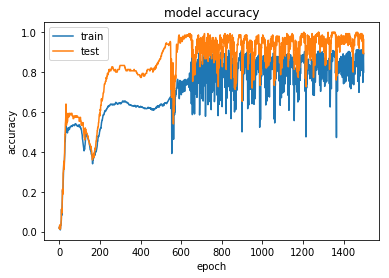

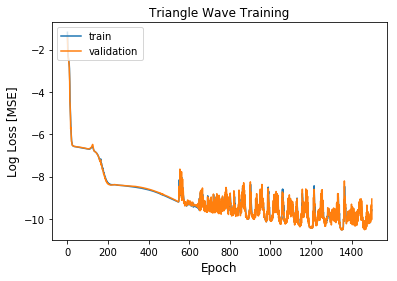

In [14]:
# list all data in history
print(history.keys())
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(np.log(history['loss']))
plt.plot(np.log(history['val_loss']))
plt.title('Triangle Wave Training')
plt.ylabel('Log Loss [MSE]', fontsize=12)
plt.xlabel('Epoch', fontsize = 12)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
from keras.models import load_model
model.save('../checkpoints/triangleLSTM_1500epoch_200neuron_180dense.h5')
#model.save('loadtime_3000epoch_100batch_200neuron_180dense_div2point3.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('loadtime_200epoch_200batch_200neuron_180dense.h5')

In [26]:
from keras.utils import plot_model
#plot_model(model, to_file='../assets/lstm_architecture_triangle.png')


In [26]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (150, 200)                161600    
_________________________________________________________________
dense_5 (Dense)              (150, 180)                36180     
_________________________________________________________________
dense_6 (Dense)              (150, 62)                 11222     
Total params: 209,002
Trainable params: 209,002
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
def forecast_lstm(model, X, n_batch):
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [13]:
#Run on test data
test_x, test_y = test[0:n_prev], test[n_prev:]
test_x = np.array(test_x)
y_hat = forecast_lstm(model, test_x, n_batch)
avg_RMSE = math.sqrt(mean_squared_error(test_y, y_hat))

print("Average RMSE: " + str(avg_RMSE))

(150, 186)
Average RMSE: 0.0054905282326


## Mean Absolute Error (MAE) accuracy on the Validation Data, as percentage of maximum value

In [14]:
#This should be using the "height" of the wave
max_height = max(test_y) - min(test_y)
# print(max(test_y))
# print(min(test_y))
# print(max_height)

error_sum = 0
for i in range(len(test_y)):
    error_sum += abs(test_y[i] - y_hat[i])
    
avg_error_sum = error_sum/len(test_y)
mean_abs_error_percentage = (avg_error_sum/max_height)*100
print("mean_abs_error_percentage: "+str(mean_abs_error_percentage))

mean_abs_error_percentage: 0.43895684600842083


## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

Epochs: 1500
Average RMSE: 0.0054905282326
mean_abs_error_percentage: 0.43895684600842083
Average predicted value: 0.5084192499878907
Variance of predicted values: 0.08077211
Min: 0.030767139 Max: 0.9756356


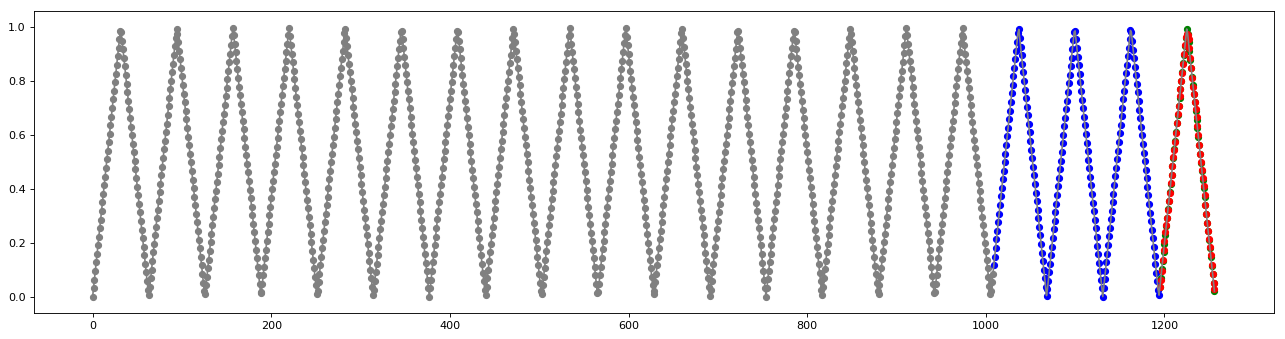

In [16]:
#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Training data in Blue
plt.plot(data, color="gray")
train_plot_x = [x for x in range(len(train_points))]
plt.scatter(train_plot_x, train_points, color="gray", s=30)

#Display the input (X) for the prediction purple
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)

test_x_indices = [x for x in range(test_x_start, test_x_end)]
test_x_labels = [data[y] for y in test_x_indices]

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)


#Define indices for which to plot the prediction
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]


#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

#Display forecasted labels in red
plt.scatter(labels_x, y_hat, color="red", s=30)



gray_patch = mpatches.Patch(color='gray', label='Training/Validation data')

blue_patch = mpatches.Patch(color='blue', label='Test input example(X)')

green_patch = mpatches.Patch(color='green', label='True labels (Y)')

red_patch = mpatches.Patch(color='red', label='Forecast (Y-hat)')

#plt.legend(handles=[gray_patch, blue_patch, green_patch, red_patch],bbox_to_anchor=(1.04,1), loc="upper left")



# from matplotlib.font_manager import FontProperties

# fontP = FontProperties()
# fontP.set_size('large')
# plt.legend([red_patch], "dfdfd", prop=fontP)

#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")




print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(avg_RMSE))
print("mean_abs_error_percentage: "+str(mean_abs_error_percentage))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))